# Predicting the success of a KickStarter project

The goal of this project is to implement the modeling process and predict the success of KickStarter project using  Logistic Regression.

The dataset was taken from Kaggle and it can be found here: https://www.kaggle.com/kemical/kickstarter-projects/data

In [59]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### 1. Load & Describe the Dataset

In [2]:
df = pd.read_csv('KickStarter_2018.csv')

In [3]:
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


In [4]:
#Drop columns that are not needed for the modelling process.
kick = df.drop(['name', 'currency', 'pledged', 'goal', 'usd pledged', 'deadline', 'launched'], axis=1)

#Rename columns
kick = kick.rename(columns={'usd_pledged_real': 'pledged', 'usd_goal_real': 'goal'})

kick.head()

,ID,category,main_category,state,backers,country,pledged,goal
0,1000002330,Poetry,Publishing,failed,0,GB,0.0,1533.95
1,1000003930,Narrative Film,Film & Video,failed,15,US,2421.0,30000.00
2,1000004038,Narrative Film,Film & Video,failed,3,US,220.0,45000.00
3,1000007540,Music,Music,failed,1,US,1.0,5000.00
4,1000011046,Film & Video,Film & Video,canceled,14,US,1283.0,19500.00


### Dictionary of the dataset

FieldName|Type|Description
---------|----|-----------
ID| String| ID of the project
category| String| The detailed description of project's category
main_category| String| The high-level description of project's category
state| String| Indicates whether the project succeded or not
backers|Integer|Number of people who backed the project
country| String| The country of origin
pledged| Float|The ammount pledged
goal|Float|The goal amount




### 2. Definition of  the Classification problem
We will attempt logistic regression classification on order to evaluate whether the success of a project can be predicted by:

1. The category of a project alone
2. The region of the project
3. The combination of the two factors

The target variable will be "state"

We will evaluate our results based on the precision and recall of the model. Given that as investors we get our money back when I project doesn't get fully backed, we can afford having lower precision. Therefore recall is more impotant in this context, as we don't want to miss the opportunity to invest in a profitable project.

### 3. Prepare dataframe for analysis: Data cleaning and feature manipulation.


In [5]:
#Check for missing values

kick.isnull().sum()

ID               0
category         0
main_category    0
state            0
backers          0
country          0
pledged          0
goal             0
dtype: int64

In [6]:
kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 8 columns):
ID               378661 non-null int64
category         378661 non-null object
main_category    378661 non-null object
state            378661 non-null object
backers          378661 non-null int64
country          378661 non-null object
pledged          378661 non-null float64
goal             378661 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 23.1+ MB


In [7]:
#Explore the values of the target variable 'State'

kick.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [8]:
#We want to keep only projects for which the state is either "failed" or "success".

kick = kick[kick.state != 'undefined']
kick = kick[kick.state != 'live']
kick = kick[kick.state != 'suspended']
kick = kick[kick.state != 'canceled']

kick.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [9]:
len(kick)

331675

In [10]:
# Convert state to numeric values

kick['state'] = kick.state.map({'failed': 0, 'successful': 1})

kick.state.value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [11]:
kick.head()

,ID,category,main_category,state,backers,country,pledged,goal
0,1000002330,Poetry,Publishing,0,0,GB,0.0,1533.95
1,1000003930,Narrative Film,Film & Video,0,15,US,2421.0,30000.00
2,1000004038,Narrative Film,Film & Video,0,3,US,220.0,45000.00
3,1000007540,Music,Music,0,1,US,1.0,5000.00
5,1000014025,Restaurants,Food,1,224,US,52375.0,50000.00


### 4. Run a logistic regression using "main_category" as the predictor variable


In [12]:
kick.main_category.value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

We will group the different categories into larger categories, in order to make the analysis easier.

In [13]:
#Digital Art category
kick['main_category']=np.where(kick['main_category'] =='Film & Video', 'Digital Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Photography', 'Digital Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Games', 'Digital Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Design', 'Digital Art', kick['main_category'])



#Art category
kick['main_category']=np.where(kick['main_category'] =='Music', 'Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Theater', 'Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Fashion', 'Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Crafts', 'Art', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Dance', 'Art', kick['main_category'])


#Media category
kick['main_category']=np.where(kick['main_category'] =='Comics', 'media', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Journalism', 'media', kick['main_category'])
kick['main_category']=np.where(kick['main_category'] =='Publishing', 'media', kick['main_category'])




In [14]:
kick.main_category.value_counts()

Digital Art    120101
Art            112998
media           49472
Technology      27050
Food            22054
Name: main_category, dtype: int64

In [15]:
kick.groupby('main_category').mean()['state']

main_category
Art            0.462725
Digital Art    0.416283
Food           0.275914
Technology     0.237856
media          0.387168
Name: state, dtype: float64

Based on the above, we can see that we are dealing with an imbalanced dataset. The probability of a project failing to raise the goal amount is by far greater than the probability of succeeding. We should expect this to affet the performance of the classifier.

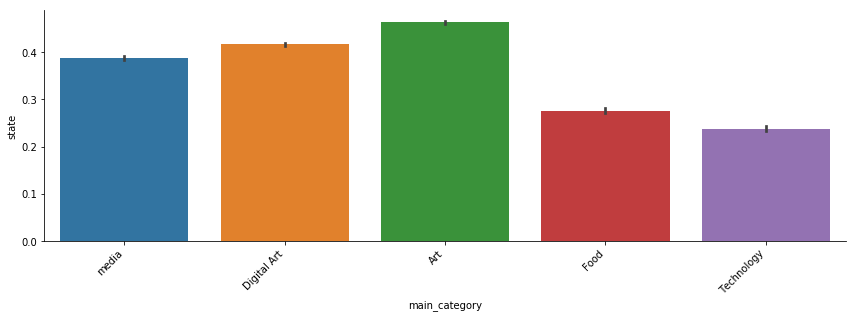

In [16]:
sns.factorplot(x='main_category', y='state', 
               data=kick, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

In [17]:
#Create dummy variables 
dum_category = pd.get_dummies(kick.main_category, drop_first=True)

#Concat the dummies
kick = pd.concat([kick, dum_category], axis=1)

kick.head()

,ID,category,main_category,state,backers,country,pledged,goal,Digital Art,Food,Technology,media
0,1000002330,Poetry,media,0,0,GB,0.0,1533.95,0,0,0,1
1,1000003930,Narrative Film,Digital Art,0,15,US,2421.0,30000.00,1,0,0,0
2,1000004038,Narrative Film,Digital Art,0,3,US,220.0,45000.00,1,0,0,0
3,1000007540,Music,Art,0,1,US,1.0,5000.00,0,0,0,0
5,1000014025,Restaurants,Food,1,224,US,52375.0,50000.00,0,1,0,0


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, classification_report

In [19]:
X = kick[['Digital Art', 'Food', 'media', 'Technology']]
y = kick.state


In [20]:
#Split the dataset
X_train,X_test, y_train, y_test = train_test_split(X, y)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(248756, 4)
(248756,)
(82919, 4)
(82919,)


In [21]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = cross_val_predict(lr, X_train, y_train, cv = 5)
confusion_matrix(predictions, y_train)

array([[148102, 100654],
       [     0,      0]])

In [22]:
accuracy_score(predictions, y_train)

0.5953705639260962

In [23]:
lr.coef_, lr.intercept_

(array([[-0.19398427, -0.79913223, -0.31769778, -1.00793323]]),
 array([-0.14436503]))

In [24]:
print(classification_report(predictions, y_train))

             precision    recall  f1-score   support

          0       1.00      0.60      0.75    248756
          1       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75    248756



/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


As expected, due to the imbalanced dataset,  the classier categorizes as "fail" all the projects. This results to very high precision but low recall. 

In [25]:
cross_val_score(lr, X_train, y_train, cv = 10)

array([0.59536922, 0.59536922, 0.59535295, 0.59535295, 0.59537688,
       0.59537688, 0.59537688, 0.59537688, 0.59537688, 0.59537688])

### 5. Run a logistic regression using "country" as the predictor variable

In [26]:
kick['country'].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

There are many different countries. We will group them based on their continet, in order to make the analysis easier.

In [27]:
#Europe
kick['country']=np.where(kick['country'] =='AT', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='GB', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='DE', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='FR', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='NL', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='IT', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='ES', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='NO', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='BE', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='SE', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='DK', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='IE', 'Europe', kick['country'])
kick['country']=np.where(kick['country'] =='LU', 'Europe', kick['country'])



#North America
kick['country']=np.where(kick['country'] =='US', 'North_America', kick['country'])
kick['country']=np.where(kick['country'] =='CA', 'North_America', kick['country'])


#APAC
kick['country']=np.where(kick['country'] =='CH', 'Asia', kick['country'])
kick['country']=np.where(kick['country'] =='AU', 'Asia', kick['country'])
kick['country']=np.where(kick['country'] =='NZ', 'Asia', kick['country'])
kick['country']=np.where(kick['country'] =='HK', 'Asia', kick['country'])
kick['country']=np.where(kick['country'] =='SG', 'Asia', kick['country'])
kick['country']=np.where(kick['country'] =='JP', 'Asia', kick['country'])



#Latin America
kick['country']=np.where(kick['country'] =='MX', 'Latin_America', kick['country'])


#Drop rows with N,0 value
kick = kick[kick.country != 'N,0"']



In [28]:
kick['country'].value_counts()

North_America    273730
Europe            46828
Asia               9496
Latin_America      1411
Name: country, dtype: int64

In [29]:
kick.groupby('country').mean()['state']

country
Asia             0.320767
Europe           0.362518
Latin_America    0.280652
North_America    0.414397
Name: state, dtype: float64

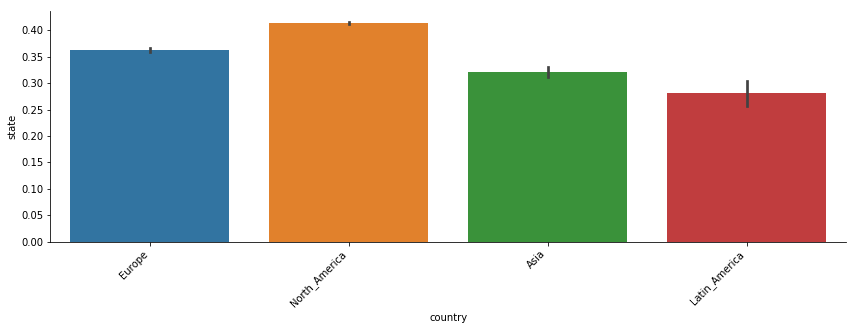

In [30]:
sns.factorplot(x='country', y='state', 
               data=kick, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

In [31]:
dummies_countries = pd.get_dummies(kick.country, drop_first=True)
dummies_countries

#Concat the dummies
kick = pd.concat([kick, dummies_countries], axis=1)
kick.head()

,ID,category,main_category,state,backers,country,pledged,goal,Digital Art,Food,Technology,media,Europe,Latin_America,North_America
0,1000002330,Poetry,media,0,0,Europe,0.0,1533.95,0,0,0,1,1,0,0
1,1000003930,Narrative Film,Digital Art,0,15,North_America,2421.0,30000.00,1,0,0,0,0,0,1
2,1000004038,Narrative Film,Digital Art,0,3,North_America,220.0,45000.00,1,0,0,0,0,0,1
3,1000007540,Music,Art,0,1,North_America,1.0,5000.00,0,0,0,0,0,0,1
5,1000014025,Restaurants,Food,1,224,North_America,52375.0,50000.00,0,1,0,0,0,0,1


In [32]:

X = kick[['Europe', 'North_America', 'Latin_America']]
y = kick.state


In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = cross_val_predict(lr, X_train, y_train, cv = 5)
confusion_matrix(predictions, y_train)

array([[148102, 100654],
       [     0,      0]])

In [34]:
accuracy_score(predictions, y_train)

0.5953705639260962

In [35]:
print(classification_report(predictions, y_train))

             precision    recall  f1-score   support

          0       1.00      0.60      0.75    248756
          1       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75    248756



/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


This classifier yielded the same results as the previous one. This is due to the imbalanced dataset. 

In [36]:
cross_val_score(lr, X_train, y_train, cv = 10)

array([0.59536922, 0.59536922, 0.59535295, 0.59535295, 0.59537688,
       0.59537688, 0.59537688, 0.59537688, 0.59537688, 0.59537688])

### 6. Run a logistic regression using "backers" as the predictor variable

In [37]:
X = kick['backers']
y = kick.state

In [38]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = cross_val_predict(lr, X_train, y_train, cv = 5)
confusion_matrix(predictions, y_train)


array([[148102, 100654],
       [     0,      0]])

In [39]:
accuracy_score(predictions, y_train)

0.5953705639260962

In [40]:
print(classification_report(predictions, y_train))

             precision    recall  f1-score   support

          0       1.00      0.60      0.75    248756
          1       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75    248756



/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


As we can see, the model's accuracy is not improving despite trying different predictor variables. This is expected, given that the input data are imbalanced.

As next step, we will try applying knn combining the different predictor variables.

### 7. Run a logistic regression using "backers"  & project category as predictor variables

In [41]:
X = kick[['backers','Digital Art', 'Food', 'media', 'Technology']]
y = kick.state

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = cross_val_predict(lr, X_train, y_train, cv = 5)
confusion_matrix(predictions, y_train)


array([[148102, 100654],
       [     0,      0]])

In [43]:
accuracy_score(predictions, y_train)

0.5953705639260962

In [44]:
print(classification_report(predictions, y_train))

             precision    recall  f1-score   support

          0       1.00      0.60      0.75    248756
          1       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75    248756



/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 8. Comparing to Baseline

In [45]:
from sklearn.dummy import DummyClassifier

In [46]:
dum_dum = DummyClassifier(strategy='most_frequent')

In [47]:
dum_dum.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [48]:
dum_dum.score(X_train,y_train)

0.5953705639260962

This means that the classifier we built is not any better than random guess. This means that **that we cannot predict the success of a project based on the category**.

### 9. Plot and interpret the following:
* Precision and Recall curves together (thresholds vs. probability)
* Precision vs. Recall
* ROC curve

In [50]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
%matplotlib notebook

Text(0,0.5,'Recall')

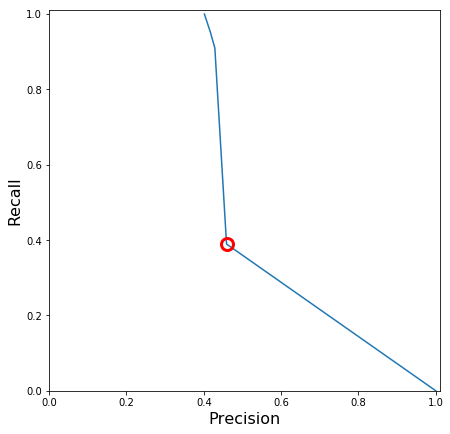

In [62]:
y_scores_lr = lr.fit(X_train, y_train).decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize = (7, 7))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)

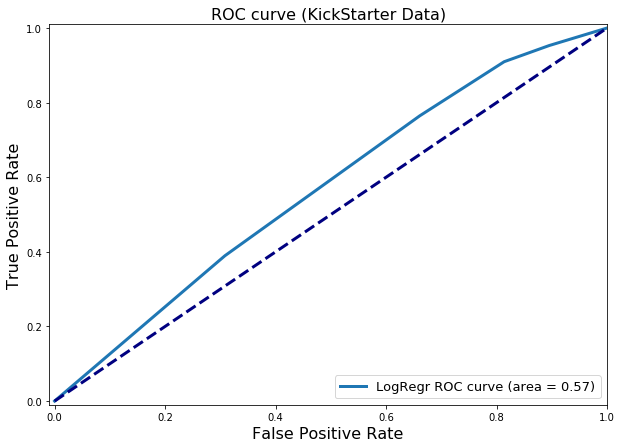

In [63]:
y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize = (10, 7))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (KickStarter Data)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

** Interpretation of ROC Curve**

A "perfect" model, has has a ROC curve that passes through the upper left corner of the plot. At this point it has the highest TP and the low FP rate. The shape of the ROC curve for this model corresponds to the low accuracy of the model. 

**Questions**
1. Why don't we evaluate the prediction based on the test data? Looking at 4.B. section of https://nbviewer.jupyter.org/github/jfkoehler/GA-Logistic-Regression/blob/master/predicting_evergreen_sites-lab%28with%20solns%29.ipynb, shouldn't we predict based on the test data?
2. How the "drop_first=True" affects the model when we create dummy variables?
3. Where cross validation fits in the modelling process? Looking at https://nbviewer.jupyter.org/github/jfkoehler/GA-Logistic-Regression/blob/master/KNN%20NHL%20Lab%28solns%29.ipynb, it happens after the modelling? 
4. Interpretation of the two curves.